In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [131]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
import datetime as dt
from itertools import product
from tqdm import tqdm_notebook as tqdm
import warnings
from scipy import stats
from scipy.special import inv_boxcox
import statsmodels.api as sm
from statsmodels.tsa import stattools

%matplotlib inline

In [3]:
data = pd.read_csv("Браузеры в России - по датам 2015-01-05-2019-10-06.csv")

In [4]:
data.head()

,Время,"Amigo, Визиты","Amigo, Доля","UC Browser, Визиты","UC Browser, Доля","Internet Explorer, Визиты","Internet Explorer, Доля","Android Browser, Визиты","Android Browser, Доля","Firefox, Визиты",...,"Google Chrome, Визиты","Google Chrome, Доля","Edge, Визиты","Edge, Доля","Samsung Internet, Визиты","Samsung Internet, Доля","MIUI browser, Визиты","MIUI browser, Доля","Остальные, Визиты","Остальные, Доля"
0,2015-01-05 - 2015-01-11,50681909,0.019028,11541176,0.004333,216571917,0.081309,129912457,0.048774,248760000,...,996266448,0.374033,0,0.0,0,0.0,0,0.0,58935918,0.022127
1,2015-01-12 - 2015-01-18,52409961,0.016992,12109735,0.003926,304830205,0.098827,132634207,0.043001,326669857,...,1157462396,0.375255,0,0.0,0,0.0,0,0.0,62964816,0.020413
2,2015-01-19 - 2015-01-25,54733146,0.017169,12718670,0.003990,315021803,0.098815,134674237,0.042244,335995911,...,1197241321,0.375548,0,0.0,0,0.0,0,0.0,64773527,0.020318
3,2015-01-26 - 2015-02-01,54703505,0.017098,13420135,0.004195,316889884,0.099048,134898722,0.042164,337768850,...,1199747941,0.374995,0,0.0,0,0.0,0,0.0,64566072,0.020181
4,2015-02-02 - 2015-02-08,54488961,0.017157,14048150,0.004423,311738324,0.098158,133583320,0.042062,333865785,...,1195710994,0.376499,0,0.0,0,0.0,0,0.0,63722819,0.020065


In [5]:
data.columns

Index(['Время', 'Amigo, Визиты', 'Amigo, Доля', 'UC Browser, Визиты',
       'UC Browser, Доля', 'Internet Explorer, Визиты',
       'Internet Explorer, Доля', 'Android Browser, Визиты',
       'Android Browser, Доля', 'Firefox, Визиты', 'Firefox, Доля',
       'Opera, Визиты', 'Opera, Доля', 'Safari, Визиты', 'Safari, Доля',
       'Яндекс.Браузер, Визиты', 'Яндекс.Браузер, Доля',
       'Google Chrome, Визиты', 'Google Chrome, Доля', 'Edge, Визиты',
       'Edge, Доля', 'Samsung Internet, Визиты', 'Samsung Internet, Доля',
       'MIUI browser, Визиты', 'MIUI browser, Доля', 'Остальные, Визиты',
       'Остальные, Доля'],
      dtype='object')

In [21]:
data_yandex = data[['Время', 'Яндекс.Браузер, Визиты']].copy()
data_yandex.index = data_yandex['Время'].apply(lambda x: dt.datetime.strptime(x[13:], '%Y-%m-%d'))
data_yandex.drop('Время', axis=1, inplace=True)
data_yandex.rename({'Яндекс.Браузер, Визиты': 'Yandex_browser_visits'}, axis=1, inplace=True)

In [22]:
data_yandex.head()

,Yandex_browser_visits
Время,
2015-01-11,327999377
2015-01-18,351278446
2015-01-25,367119713
2015-02-01,368903905
2015-02-08,368813514


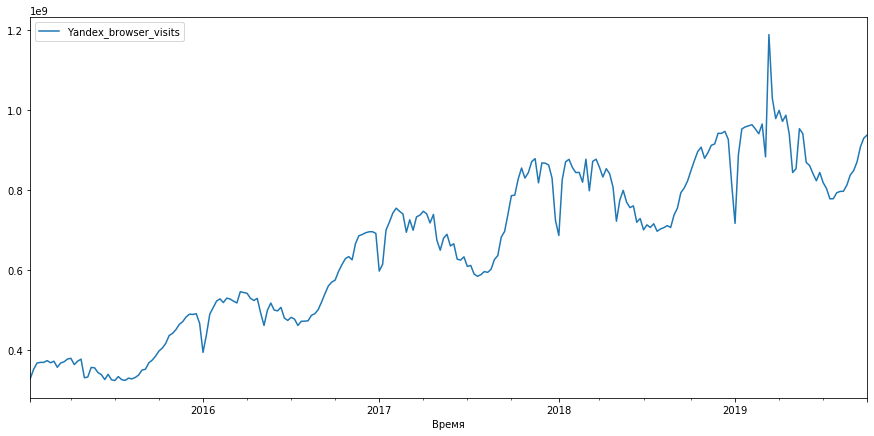

In [23]:
data_yandex.plot(figsize=(15,7))

In [34]:
def acf_pacf_plot(data, lags=40):
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    fig.tight_layout()

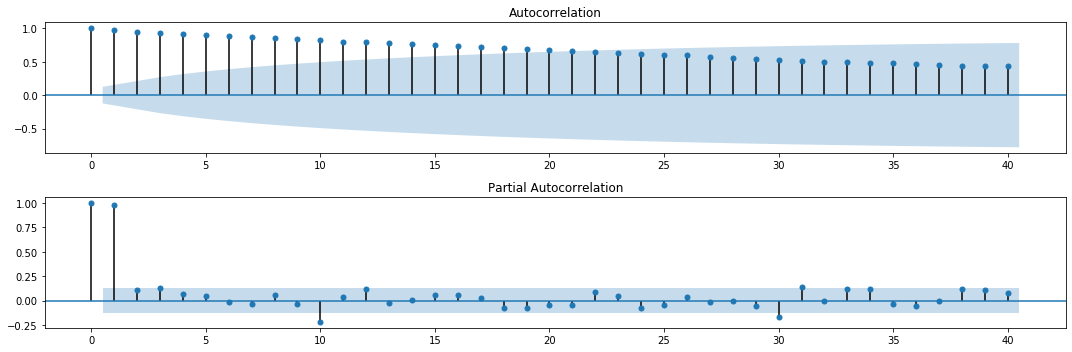

In [35]:
acf_pacf_plot(data_yandex['Yandex_browser_visits'])

#### Судя по графику, ряд не является стационарным, что подтверждается критерием Дики-Фулера 

In [36]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_yandex['Yandex_browser_visits'])[1])

Критерий Дики-Фуллера: p=0.680289


In [40]:
def adfuller(data):
    df_stat = sm.tsa.adfuller(np.array(data))
    print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
          (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))
    print('Not stationary' if df_stat[0] > df_stat[4]['5%'] else 'Stationary')

In [41]:
adfuller(data_yandex['Yandex_browser_visits'])

The Augmented Dickey-Fuller test statistic -1.184355, 
pvalue: 0.68 
maximal Lag: 16 
critical values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}
Not stationary


## Применим преобразование Бокса-Кокса

In [26]:
data_yandex['Visits_bc'], lmbda = stats.boxcox(data_yandex['Yandex_browser_visits'])

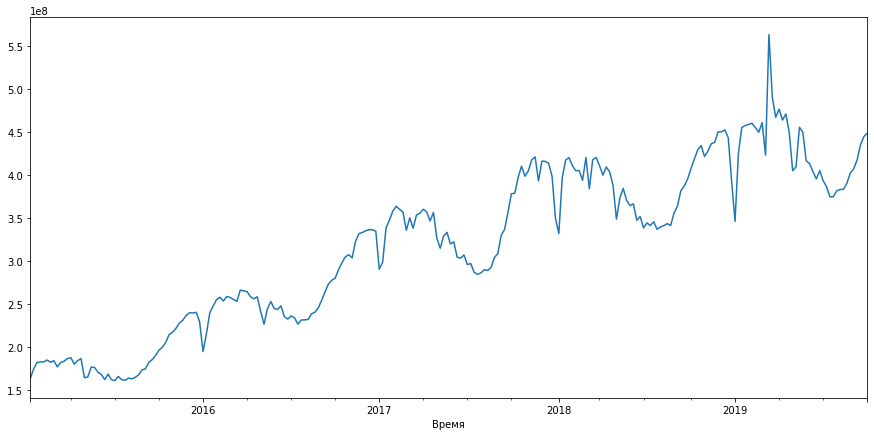

In [38]:
data_yandex['Visits_bc'].plot(figsize=(15,7))

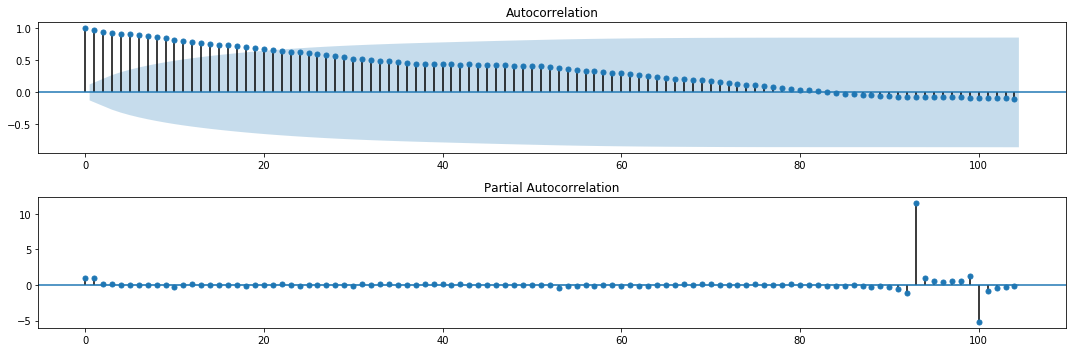

In [97]:
acf_pacf_plot(data_yandex['Visits_bc'], lags=104)

In [98]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_yandex['Visits_bc'])[1])

Критерий Дики-Фуллера: p=0.674831


In [99]:
adfuller(data_yandex['Visits_bc'])

The Augmented Dickey-Fuller test statistic -1.197125, 
pvalue: 0.67 
maximal Lag: 16 
critical values: {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}
Not stationary


##### Всё ещё не стационарен

## Уберём сезонность

In [179]:
data_yandex['Seasonal_visits_bc'] = data_yandex['Visits_bc'].diff(52)

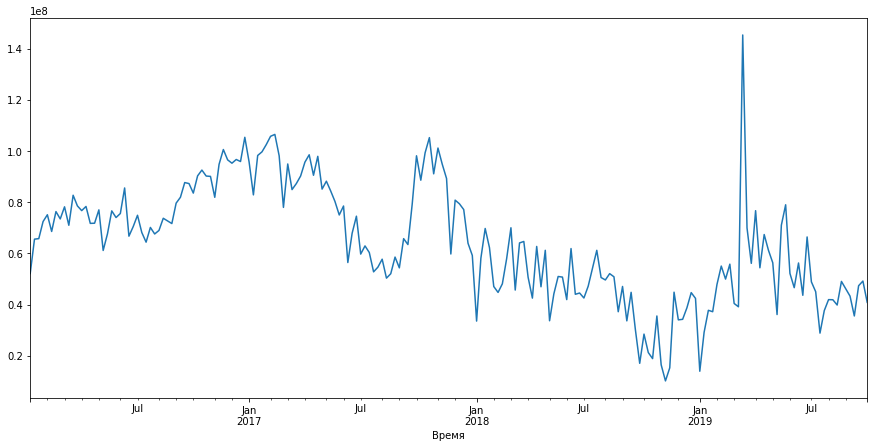

In [180]:
data_yandex['Seasonal_visits_bc'][52:].plot(figsize = (15, 7))

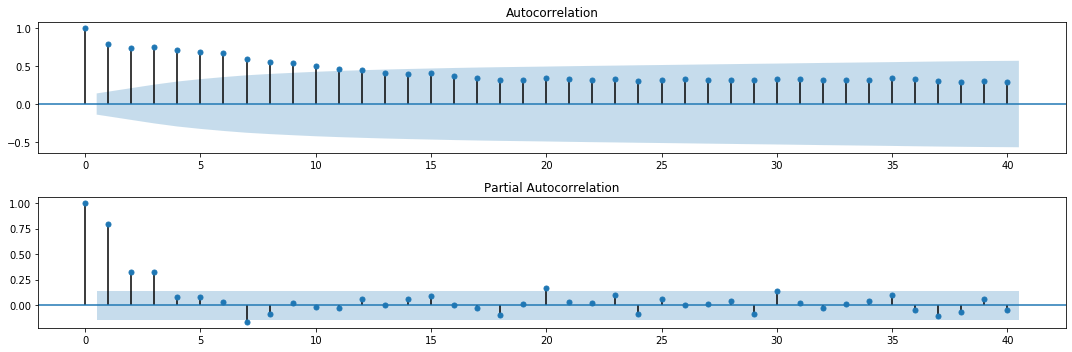

In [181]:
acf_pacf_plot(data_yandex['Seasonal_visits_bc'][52:], lags=40)

In [182]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_yandex['Seasonal_visits_bc'][52:])[1])

Критерий Дики-Фуллера: p=0.232022


In [183]:
adfuller(data_yandex['Seasonal_visits_bc'][52:])

The Augmented Dickey-Fuller test statistic -2.131542, 
pvalue: 0.23 
maximal Lag: 2 
critical values: {'1%': -3.4646940755442612, '5%': -2.8766348847254934, '10%': -2.5748163958763994}
Not stationary


##### Уже выглядит лучше. Однако всё ещё не стационарен

### Рассмотрим ряд первых разностей

In [184]:
data_yandex['Diff_s_visits_bc'] = data_yandex['Seasonal_visits_bc'].diff(1)

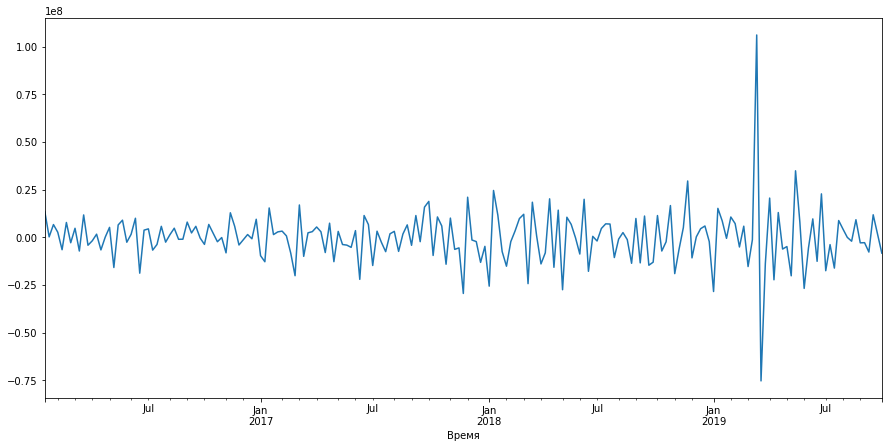

In [185]:
data_yandex['Diff_s_visits_bc'][53:].plot(figsize = (15, 7))

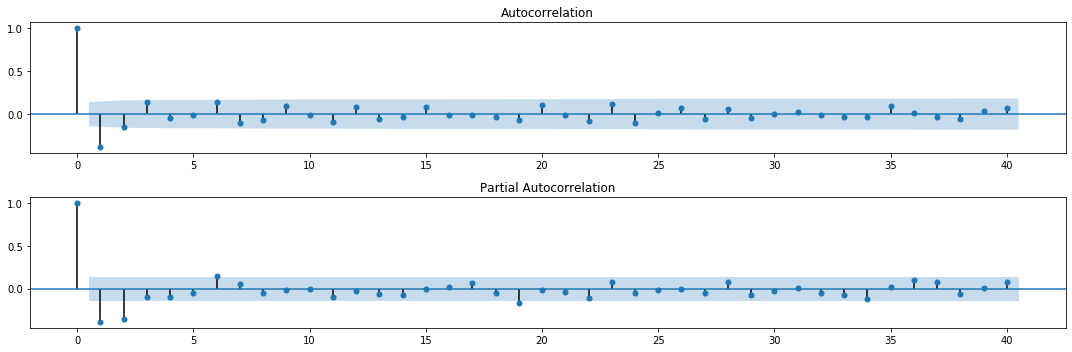

In [186]:
acf_pacf_plot(data_yandex['Diff_s_visits_bc'][53:])

In [187]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_yandex['Diff_s_visits_bc'][53:])[1])

Критерий Дики-Фуллера: p=0.000000


In [188]:
adfuller(data_yandex['Diff_s_visits_bc'][53:])

The Augmented Dickey-Fuller test statistic -11.743562, 
pvalue: 0.00 
maximal Lag: 2 
critical values: {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}
Stationary


##### Ряд первых разностей стационарен, следовательно наш ряд - интегрированный ряд первого порядка

## SARIMA

##### Подберем наилучшие параметры

In [189]:
p_range = range(0, 6)
d = 1
q_range = range(0, 5)

#params = list(product(p_range, q_range))

P_range = range(0, 6)
D = 1
Q_range = range(0, 2)

params = list(product(p_range, q_range, P_range, Q_range))

In [190]:
warnings.filterwarnings('ignore')
best_aic = float("inf")

for par in tqdm(params):
    try:
        sarima_model = sm.tsa.SARIMAX(data_yandex['Visits_bc'].astype(float),
                                     order=(par[0], d, par[1]),
                                     seasonal_order=(par[2], D, par[3], 4)).fit()
        #arima_model = sm.tsa.ARIMA(data_yandex['Visits_bc'].astype(float), (par[0], d, par[1]))
    except:
        #print('wrong parameters:', par)
        continue
        
    aic = sarima_model.aic
    
    if aic < best_aic:
        best_aic = aic
        best_param = par
warnings.filterwarnings('default')

print('p: %d d: 1 q: %d P: %d Q: %d aic: %f' % (best_param[0], best_param[1], best_param[2], best_param[3], best_aic))


p: 5 d: 1 q: 4 P: 2 Q: 1 aic: 8847.292427


In [192]:
#new_model = sm.tsa.ARIMA(data_yandex['Visits_bc'].astype(float), (best_param[0], d, best_param[1])).fit()
new_model = sm.tsa.SARIMAX(data_yandex['Visits_bc'].astype(float),
                                     order=(best_param[0], d, best_param[1]),
                                     seasonal_order=(best_param[2], D, best_param[3], 52)).fit()

/home/anatoly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [193]:
print(new_model.summary())  

                                 Statespace Model Results                                 
Dep. Variable:                          Visits_bc   No. Observations:                  248
Model:             SARIMAX(5, 1, 4)x(2, 1, 1, 52)   Log Likelihood               -3468.844
Date:                            Tue, 15 Oct 2019   AIC                           6963.688
Time:                                    22:17:38   BIC                           7006.237
Sample:                                01-11-2015   HQIC                          6980.915
                                     - 10-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7837      0.288     -2.717      0.007      -1.349      -0.218
ar.L2         -1.1463      0.362   

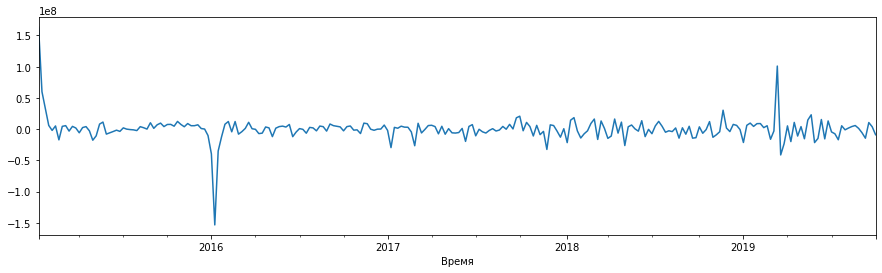

In [194]:
new_model.resid.plot(figsize=(15,4));

In [195]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(new_model.resid)[1])

Критерий Дики-Фуллера: p=0.000000


In [196]:
adfuller(new_model.resid)

The Augmented Dickey-Fuller test statistic -15.249309, 
pvalue: 0.00 
maximal Lag: 0 
critical values: {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}
Stationary


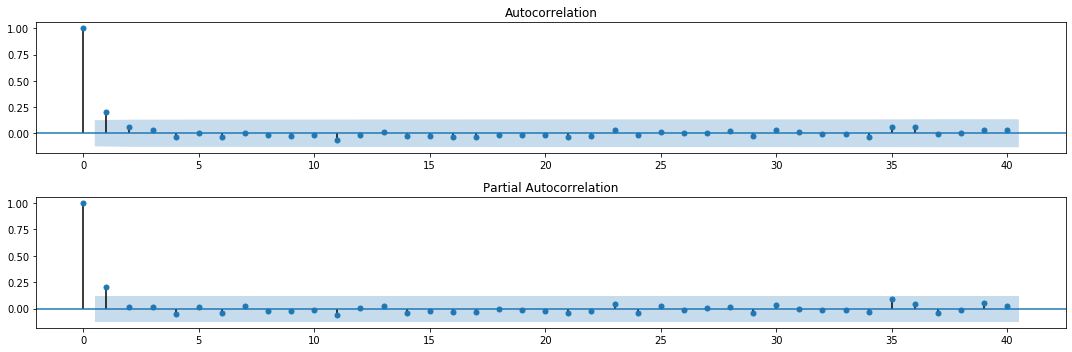

In [197]:
acf_pacf_plot(new_model.resid)

##### Остатки стационарны

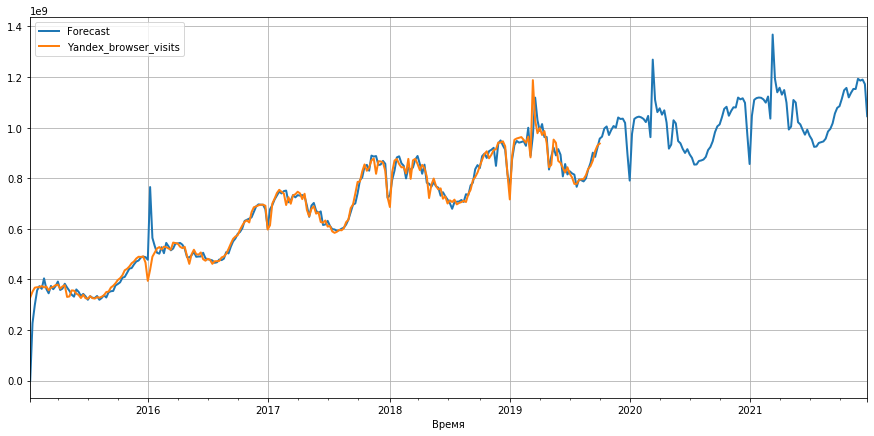

In [218]:
data_yandex["Model"] = inv_boxcox(new_model.fittedvalues, lmbda)
forecast = inv_boxcox(new_model.predict(start = data.shape[0], end = data.shape[0] + 115), lmbda)
forecast = data_yandex.Model.append(forecast)
actual = data_yandex['Yandex_browser_visits']
plt.plot()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
forecast.plot(figsize=(15,7), label='Forecast', linewidth=2)
actual.plot(linewidth=2)
plt.legend()
plt.grid()

### Пик, наблюдаемый в марте 2019 года может быть связан с изменением методологии подсчета долей браузеров, а соответственно может являтся выбросом

### Прогноз построен из предположения, что тренд имеющийся на данный момент сохранится и что никаких критических изменений в посещаемости, например, по причинам возможных изменений в популярности Яндекс браузера у пользователей, не произойдет